# 2021-11-12 Looking at model behaviour with noisy perception

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/c862930f32f78f6b9906ec37e7b97347cc569130 (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

I have made a small modification to `sc_scenario_perception.Perception`, so that the perceived speeds it reports are truncated to always be $\geq$ 0. This was because with the current implementation of value estimation in `SCAgent`, negative speeds for the other agent (typically? always?) make the values for both outcomes negative infinity for the ego agent. This could be improved with some work, but the effect of improving it would be the same as just setting those speeds to zero I believe, so therefore I opted for this simpler solution.

Since there were no code changes to `sc_scenario.py` or similar, I am not rerunning unit tests here.

## Init

In [19]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
if not (parent_path in sys.path):
    sys.path.append(parent_path)
print(sys.path)

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
import sc_scenario_perception
from sc_scenario_helper import CtrlType

['C:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\python39.zip', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\DLLs', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64', '', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\Pythonwin', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'C:\\GITHUB\\COMMOTIONSFramework']


## Just testing random seeding in numpy

From some other testing I got a vague suspicion that random seeds i and i+1 yielded similar random sequences, but that doesn't seem to be the case:

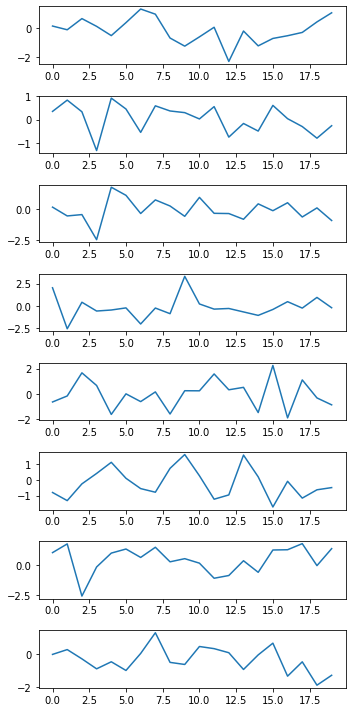

In [18]:
import matplotlib.pyplot as plt
N_RUNS = 8
fig, axs = plt.subplots(N_RUNS, 1, figsize = (5,10))
for i in range(N_RUNS):
    rng = np.random.default_rng(seed = i)
    r = rng.normal(size=20)
    axs[i].plot(r)
plt.tight_layout()

## Different model variants

### `oVAoSNvoPFoEA` - nicely exhibiting hesitation and speedup

First just looking at `oVAoSNvoPFoEA`, with a parameterisation and random seed that I had previously found generated the sort of "hesitation and speedup" behaviour that I have had a hard time generating with the deterministic models.

(seed = 20)


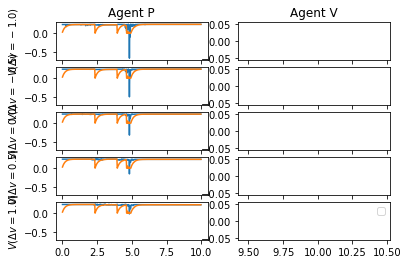

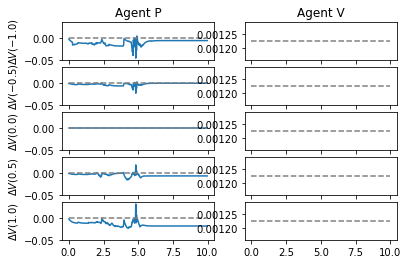

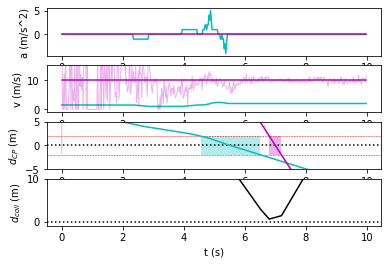

In [20]:
def run_ped_lead_scenario(model, time_step = 0.025, end_time = 10, n_simulations = 1, 
                          obs_noise_scaling = 1, val_noise_scaling = 1, first_seed = 0,
                            plot_beh_probs = False, plot_beh_activs = False, 
                            plot_beh_accs = False, plot_action_val_ests = False,
                            plot_surplus_action_vals = False,
                            ped_snaps = None, veh_snaps = None):

    NAMES = ('P', 'V')
    CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION)
    EFF_WIDTHS = (0.8, 1.8)
    GOALS = np.array([[0, 5], [-50, 0]])
    INITIAL_POSITIONS = np.array([[0, -8], [70, 0]])
    SPEEDS = np.array((1.5, 10))
    CONST_ACCS = (None, 0)
    
    optional_assumptions = sc_scenario.get_assumptions_dict_from_string(model)
    (params, params_k) = sc_scenario.get_default_params(oVA = True)
    sc_scenario.SHARED_PARAMS.d_C = 2
    params.T_s = 0
    params.D_s = 0
    params.T = 0.2
    if 'oSNv' in model:
        params.tau = 0.05 * obs_noise_scaling
    elif 'oSNc' in model:
        params.tau = 20 * obs_noise_scaling
    params.sigma_xdot = 0.1
    params.DeltaV_th_rel = 0.005
    params.sigma_V = 0.01 * val_noise_scaling

    KALMAN_PRIOR_SD_MULT = 2
    KALMAN_PRIORS = []
    for i_agent in range(2):
        i_oth = 1 - i_agent
        oth_dist = np.amax(np.abs(INITIAL_POSITIONS[i_oth, :]))
        oth_speed = SPEEDS[i_oth]
        KALMAN_PRIORS.append(sc_scenario_perception.KalmanPrior(
            cp_dist_mean = oth_dist, 
            cp_dist_stddev = KALMAN_PRIOR_SD_MULT * oth_dist, 
            speed_mean = oth_speed,
            speed_stddev = KALMAN_PRIOR_SD_MULT * oth_speed))

    for i_sim in range (n_simulations):
        this_seed = first_seed + i_sim
        print(f'(seed = {this_seed})')
        sc_simulation = sc_scenario.SCSimulation(
                CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = end_time, time_step = time_step, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                noise_seeds = (this_seed, None), kalman_priors = KALMAN_PRIORS,
                eff_widths = EFF_WIDTHS, snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs,
                              action_val_ests = plot_action_val_ests, 
                              surplus_action_vals = plot_surplus_action_vals)
        
run_ped_lead_scenario('oVAoSNvoPFoEA', first_seed = 20, 
                      plot_action_val_ests = True, plot_surplus_action_vals = True)

Same model, just a few more repetitions with less details shown:

(seed = 20)


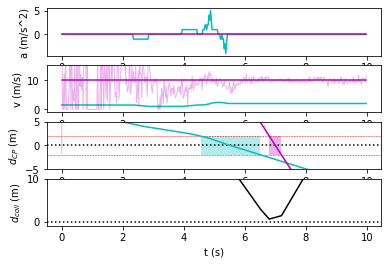

(seed = 21)


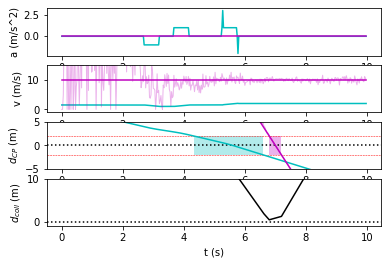

(seed = 22)


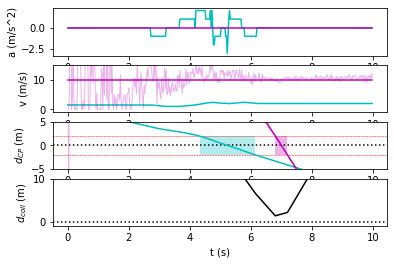

(seed = 23)


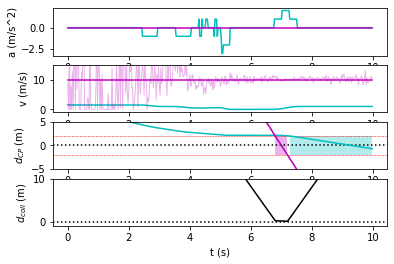

(seed = 24)


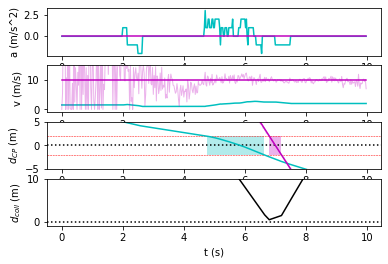

(seed = 25)


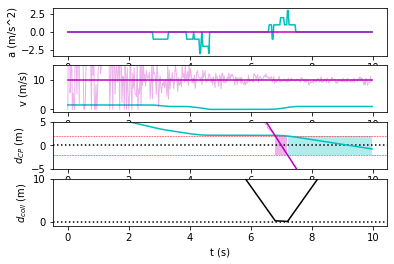

(seed = 26)


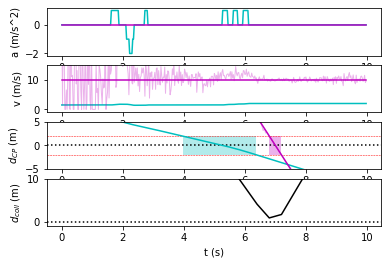

(seed = 27)


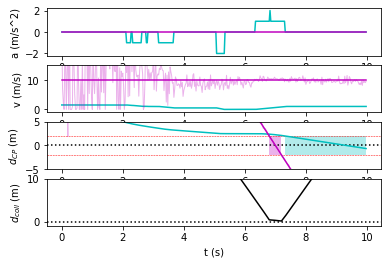

(seed = 28)


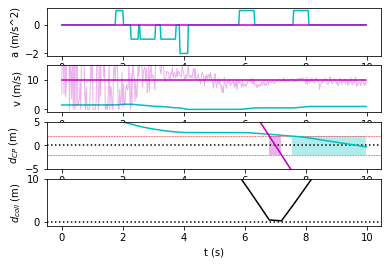

(seed = 29)


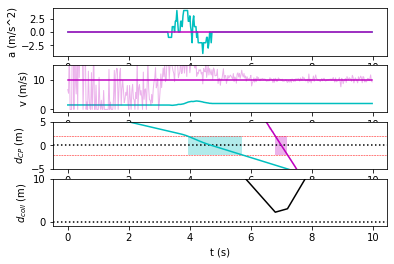

In [4]:
run_ped_lead_scenario('oVAoSNvoPFoEA', n_simulations = 10, first_seed = 20)

I was a little concerned by the first five simulations above all looking quite similar, so just to verify that at least there isn't any problem with failing to properly reinitialise the simulations, here are the five last simulations again, giving exactly the same results as above for the same seeds.

(seed = 25)


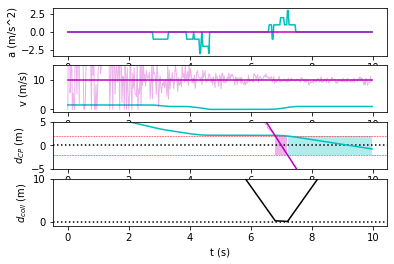

(seed = 26)


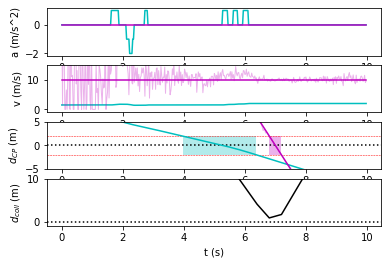

(seed = 27)


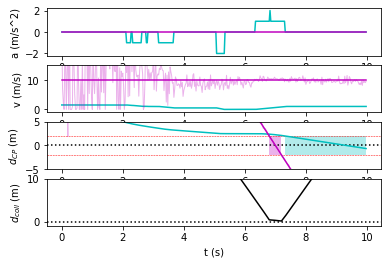

(seed = 28)


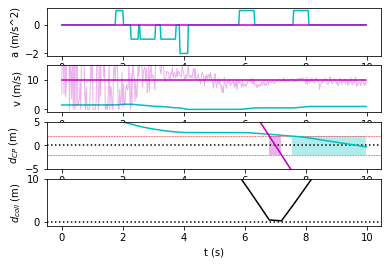

(seed = 29)


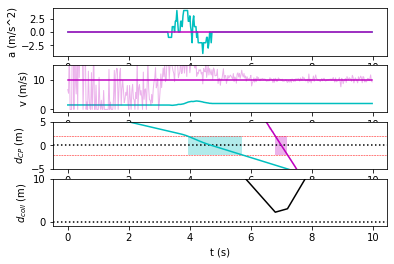

In [5]:
run_ped_lead_scenario('oVAoSNvoPFoEA', n_simulations = 5, first_seed = 25)

### `oVAoSNc` - maybe not very useful?

With just the "cartesian" noise, it seems hard to find a noise level where behaviour gets probabilistic without being erratic and collision-prone.

noise scaling = 0.01
(seed = 20)


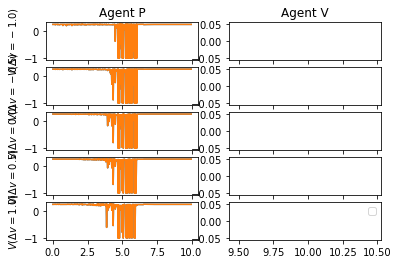

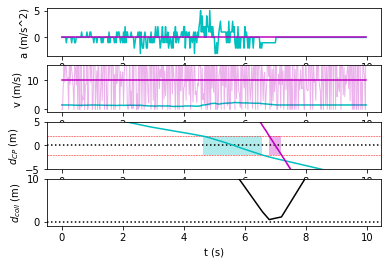

(seed = 21)


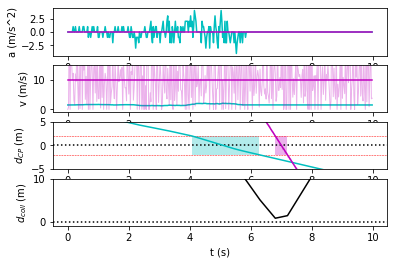

(seed = 22)


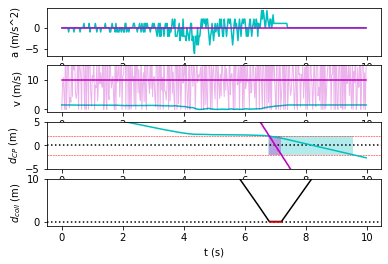

noise scaling = 0.001
(seed = 20)


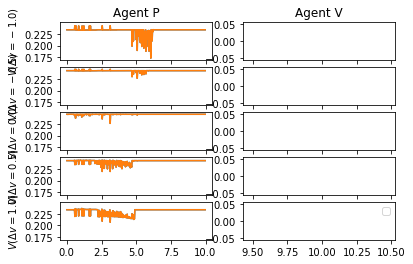

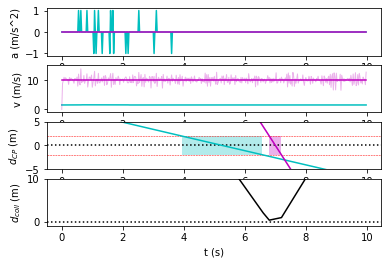

(seed = 21)


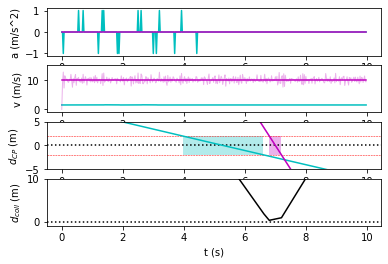

(seed = 22)


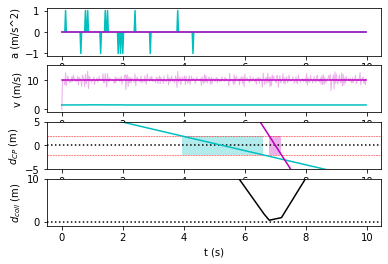

In [6]:
for obs_noise_scaling in (0.01, 0.001):
    print(f'noise scaling = {obs_noise_scaling}')
    run_ped_lead_scenario('oVAoSNc', obs_noise_scaling = obs_noise_scaling, n_simulations = 1, first_seed = 20, plot_action_val_ests = True)
    run_ped_lead_scenario('oVAoSNc', obs_noise_scaling = obs_noise_scaling, n_simulations = 2, first_seed = 21)

### `oVAoSNv` - seems pretty similar to the previous one

... and not clear that `oSNv` is much better - although in these simulations there are no collisions, presumably because the noise is reduced at closer distances:

noise scaling = 0.01
(seed = 20)


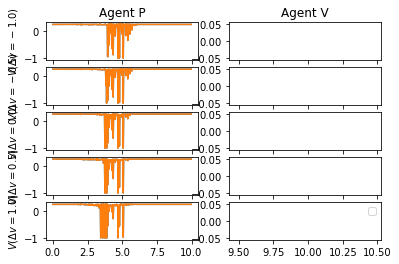

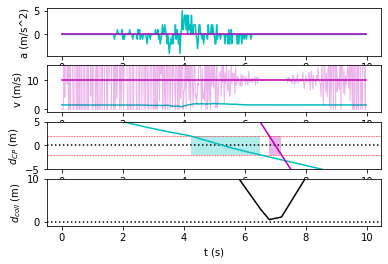

(seed = 21)


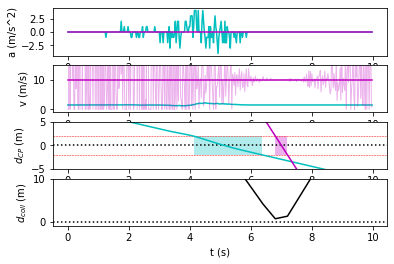

(seed = 22)


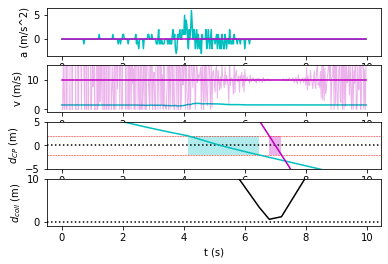

noise scaling = 0.001
(seed = 20)


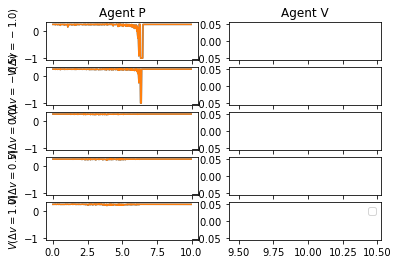

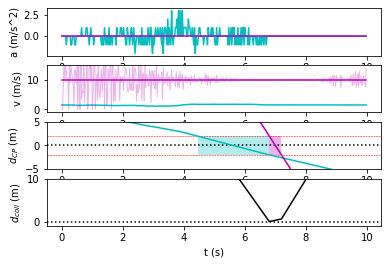

(seed = 21)


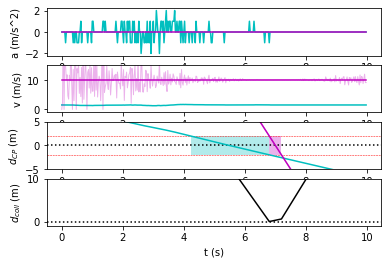

(seed = 22)


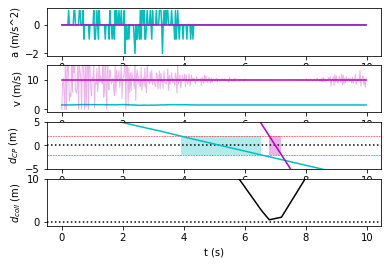

In [7]:
for obs_noise_scaling in (0.01, 0.001):
    print(f'noise scaling = {obs_noise_scaling}')
    run_ped_lead_scenario('oVAoSNv', obs_noise_scaling = obs_noise_scaling, n_simulations = 1, first_seed = 20, plot_action_val_ests = True)
    run_ped_lead_scenario('oVAoSNv', obs_noise_scaling = obs_noise_scaling, n_simulations = 2, first_seed = 21)

### `oVAoSNcoEA` - adding evidence accumulation is a nice improvement

Adding evidence accumulation seems to reduce the collision-proneness, and there is a little bit of a tendency to do hesitation + speed-up when the noise level is tuned appropriately, but that window seems pretty small.

noise scaling = 0.01
(seed = 20)


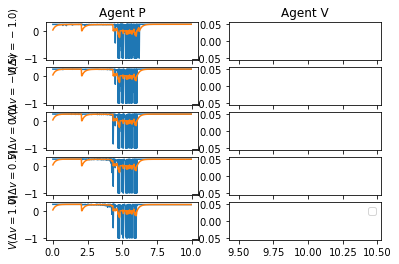

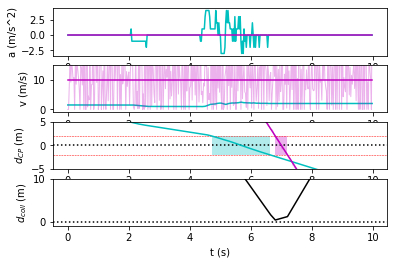

(seed = 21)


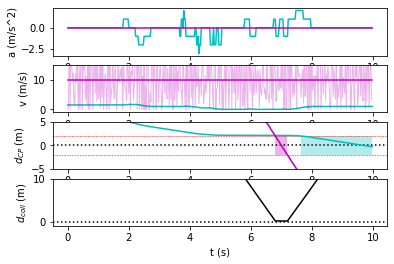

(seed = 22)


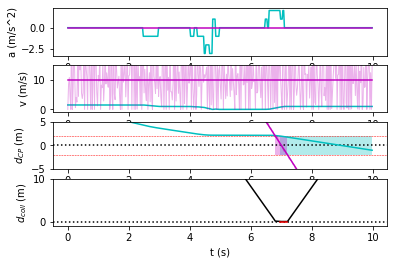

noise scaling = 0.005
(seed = 20)


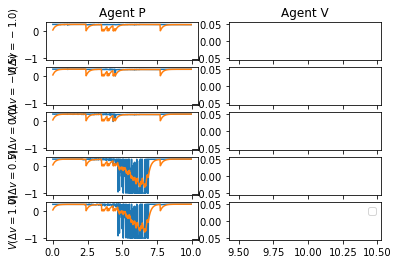

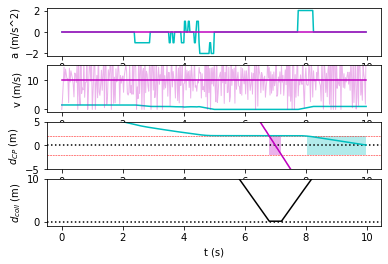

(seed = 21)


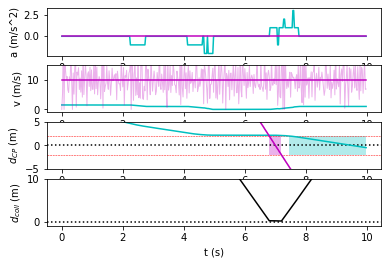

(seed = 22)


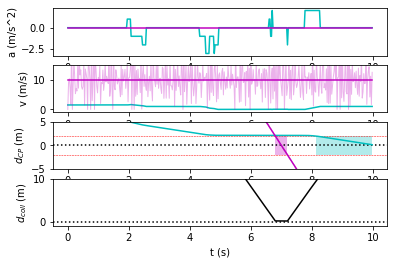

noise scaling = 0.0025
(seed = 20)


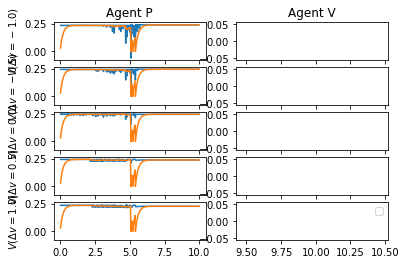

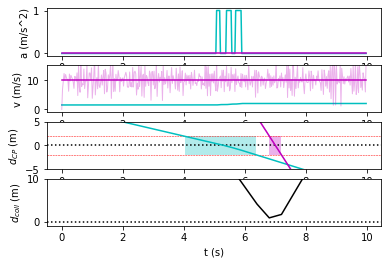

(seed = 21)


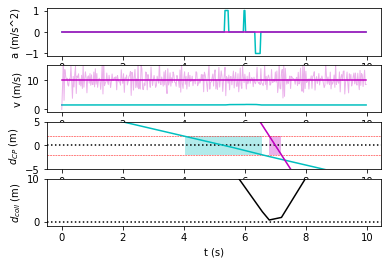

(seed = 22)


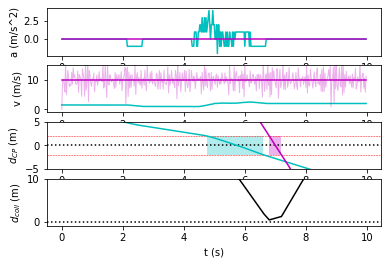

noise scaling = 0.001
(seed = 20)


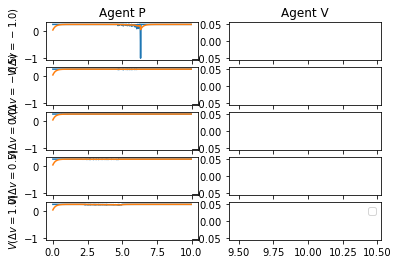

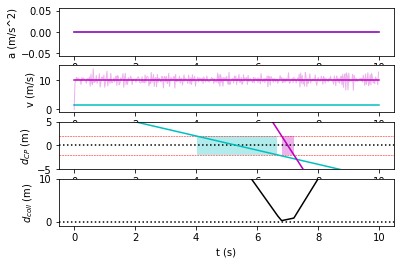

(seed = 21)


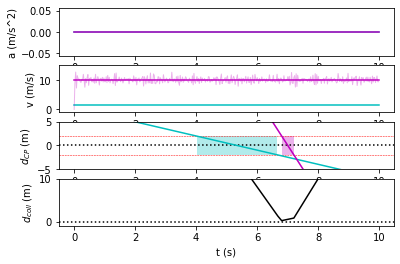

(seed = 22)


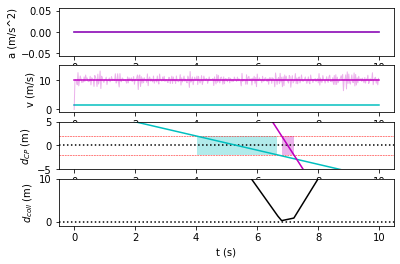

In [8]:
model = 'oVAoSNcoEA'
for obs_noise_scaling in (0.01, 0.005, 0.0025, 0.001):
    print(f'noise scaling = {obs_noise_scaling}')
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 1, first_seed = 20, plot_action_val_ests = True)
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 2, first_seed = 21)

### `oVAoSNvoEA` - seems to very nicely do hesitation and speedup

Compared to `oSNc` the tendency for full hesitation + speedup behaviour now seems more robust across simulations and noise levels. This worked better than I thought it would - I thought the Kalman filtering with draws from the estimated distribution would also be needed together with this evidence accumulation, but now when I think about it just the `oSNv` in itself isn't too far away from that already - the decreasing noise amplitude with distance isn't so far off from a Kalman-filtered decreasing estimation variance over time here. So maybe the "estimated distribution" thing isn't needed until one gets into attention control etc, as I have done in some other sketches?

noise scaling = 0.01
(seed = 20)


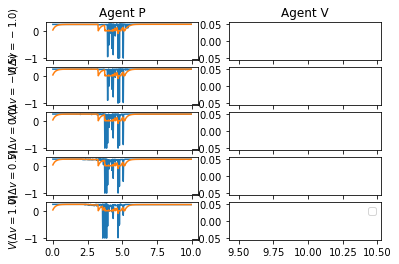

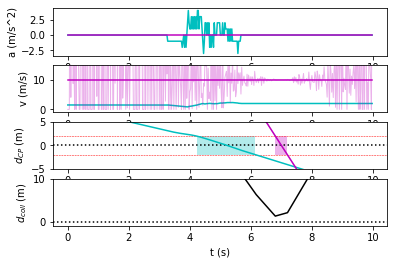

(seed = 21)


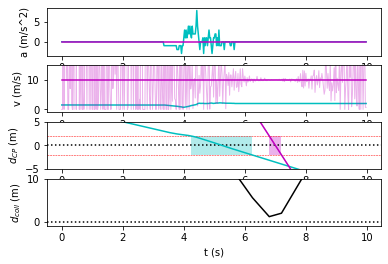

(seed = 22)


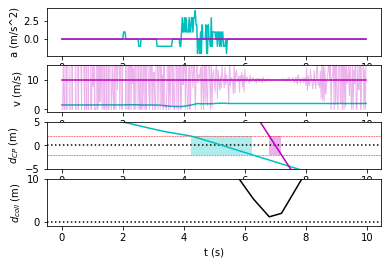

noise scaling = 0.005
(seed = 20)


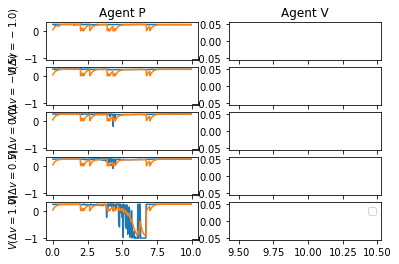

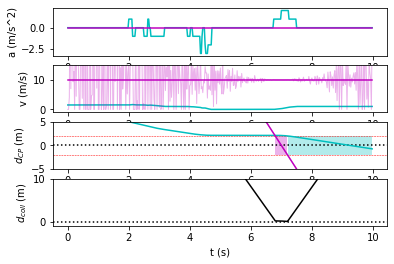

(seed = 21)


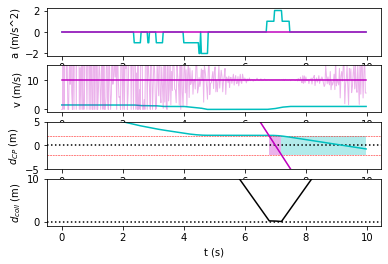

(seed = 22)


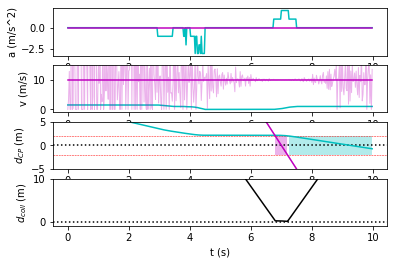

noise scaling = 0.0025
(seed = 20)


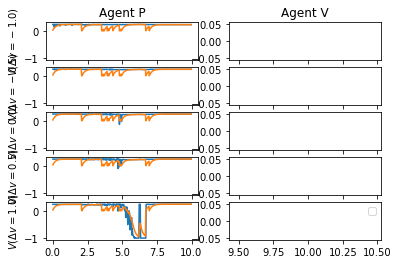

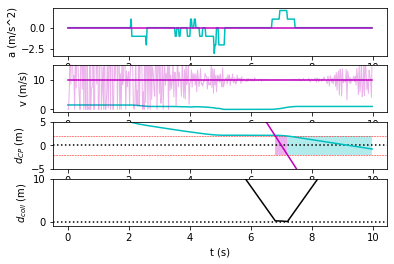

(seed = 21)


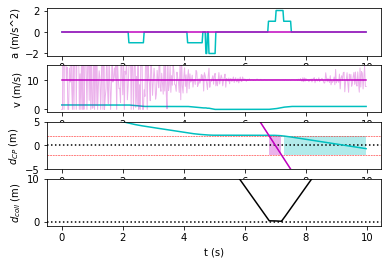

(seed = 22)


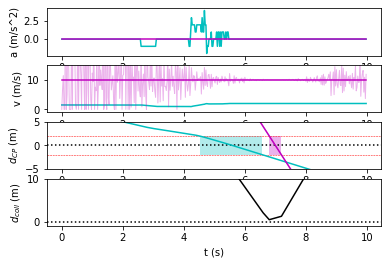

noise scaling = 0.001
(seed = 20)


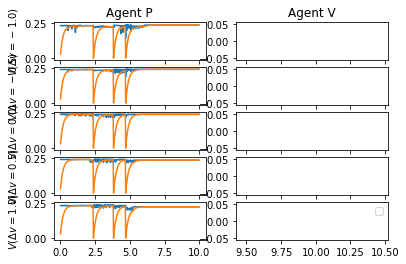

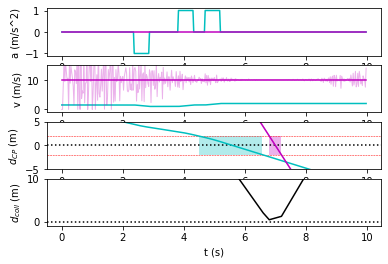

(seed = 21)


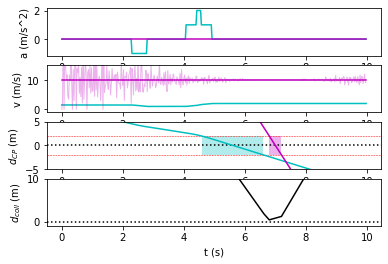

(seed = 22)


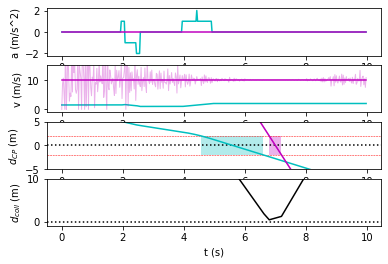

In [9]:
model = 'oVAoSNvoEA'
for obs_noise_scaling in (0.01, 0.005, 0.0025, 0.001):
    print(f'noise scaling = {obs_noise_scaling}')
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 1, first_seed = 20, plot_action_val_ests = True)
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 2, first_seed = 21)

### `oVAoSNcoPF` - also an improvement over pure `oSNc`, but not as nice-looking as with `oEA`

Adding the Kalman filtering here got rid of the collision-proneness, but the behaviour still looks a little too noisy/erratic I think. Some possible indications of hesitation + speedup for the intermediate noise scaling below, but the overall randomness makes that a bit harder to judge.

noise scaling = 5
(seed = 20)


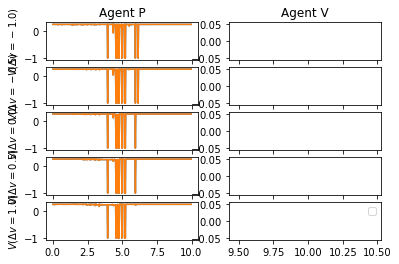

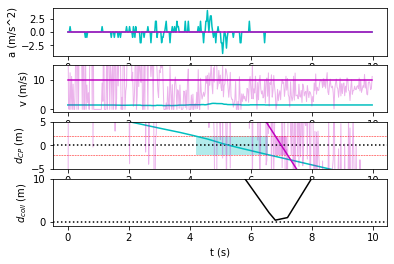

(seed = 21)


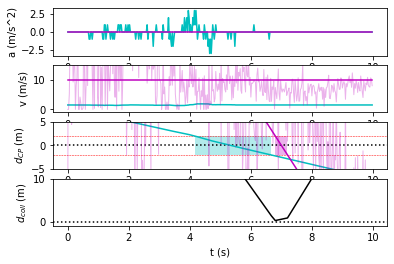

(seed = 22)


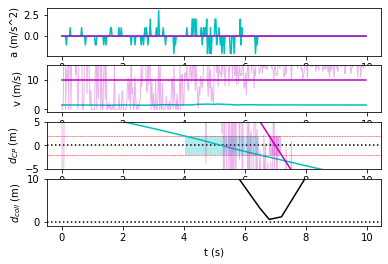

noise scaling = 1
(seed = 20)


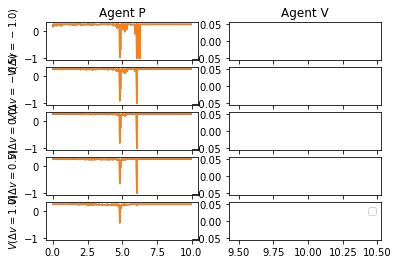

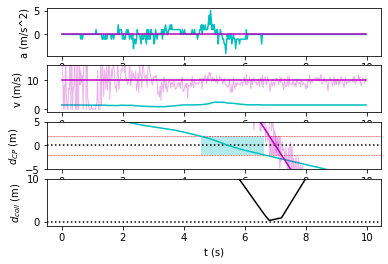

(seed = 21)


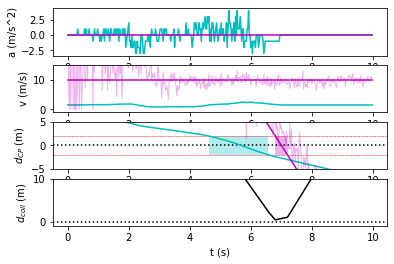

(seed = 22)


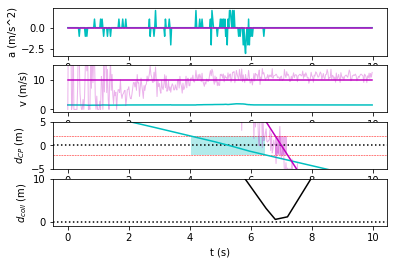

noise scaling = 0.2
(seed = 20)


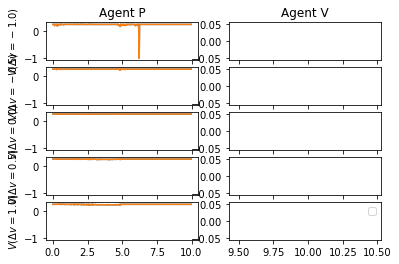

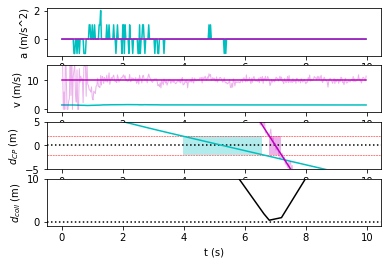

(seed = 21)


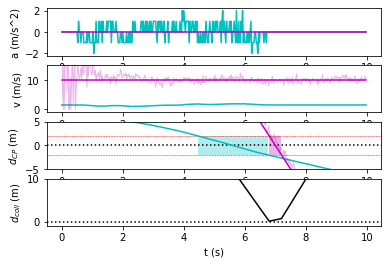

(seed = 22)


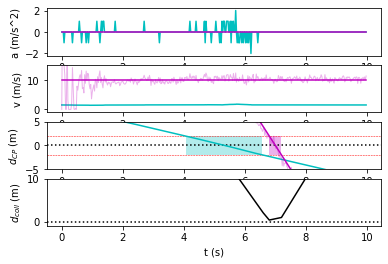

In [10]:
model = 'oVAoSNcoPF'
for obs_noise_scaling in (5, 1, 0.2):
    print(f'noise scaling = {obs_noise_scaling}')
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 1, first_seed = 20, plot_action_val_ests = True)
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 2, first_seed = 21)

### `oVAoSNvoPF` - again quite similar to the previous one

Similar to the models without `oPF`, switching to `oSNv` instead of `oSNc` here doesn't really seem to make a big difference.

noise scaling = 5
(seed = 20)


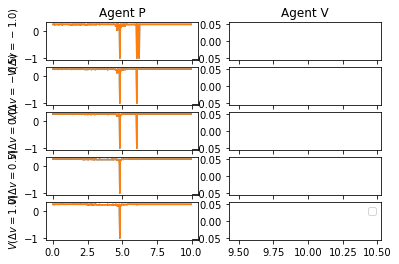

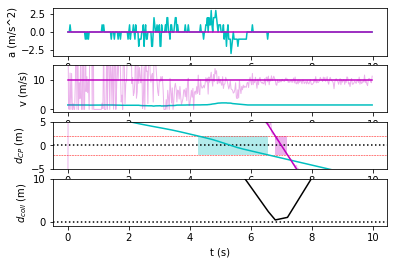

(seed = 21)


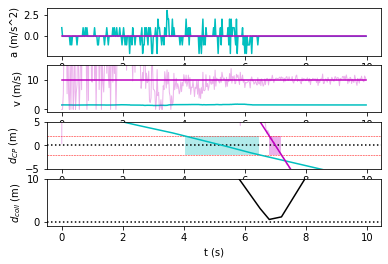

(seed = 22)


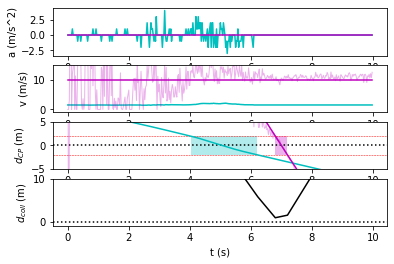

noise scaling = 1
(seed = 20)


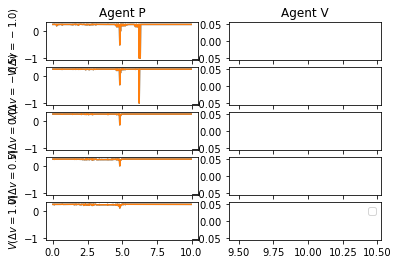

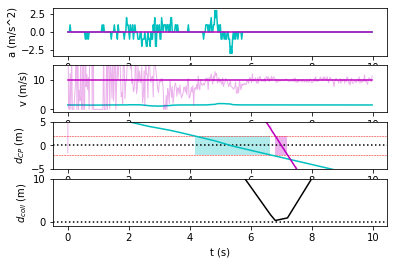

(seed = 21)


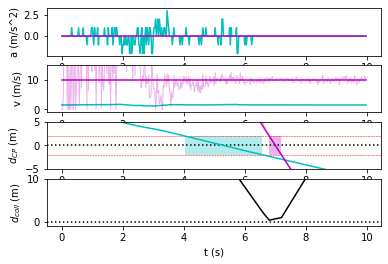

(seed = 22)


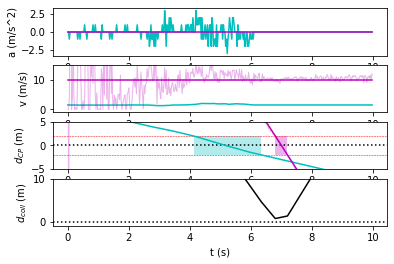

noise scaling = 0.2
(seed = 20)


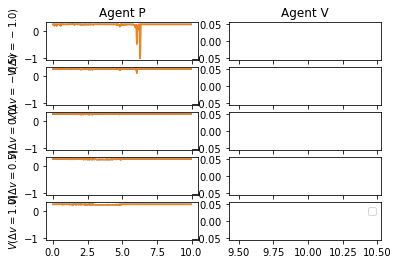

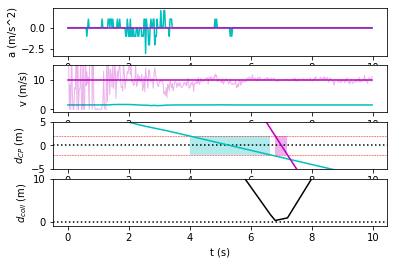

(seed = 21)


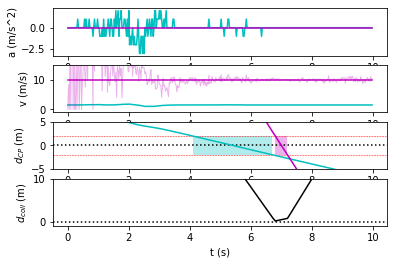

(seed = 22)


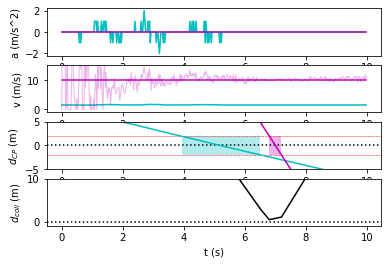

In [11]:
model = 'oVAoSNvoPF'
for obs_noise_scaling in (5, 1, 0.2):
    print(f'noise scaling = {obs_noise_scaling}')
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 1, first_seed = 20, plot_action_val_ests = True)
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 2, first_seed = 21)

### Returning to `oVAoSNvoPFoEA` - seems relatively robust to noise levels

Returning to the very first model I tested above, now just varying across the same noise level adjustments as for the other models with `oPF`. The hesitation and speedup thing remains also for the higher noise level, but disappears for the lower one.

noise scaling = 5
(seed = 20)


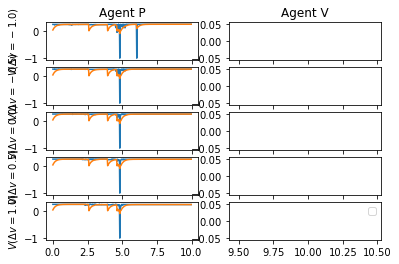

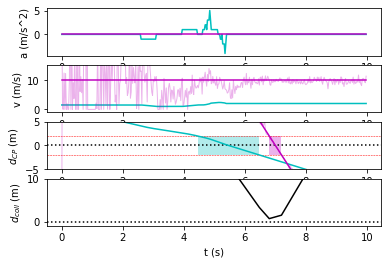

(seed = 21)


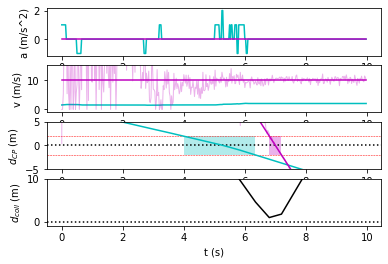

(seed = 22)


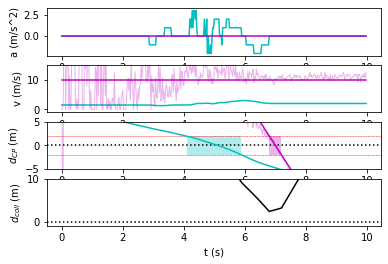

noise scaling = 1
(seed = 20)


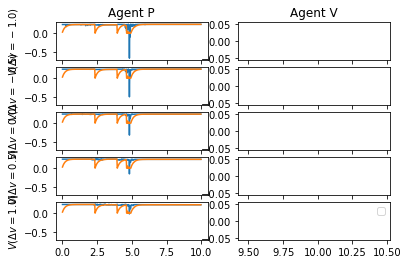

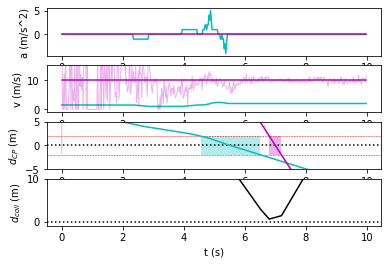

(seed = 21)


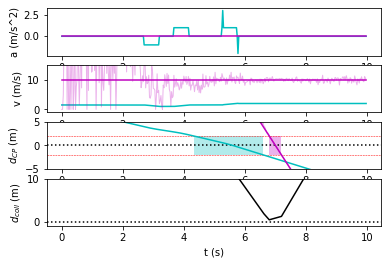

(seed = 22)


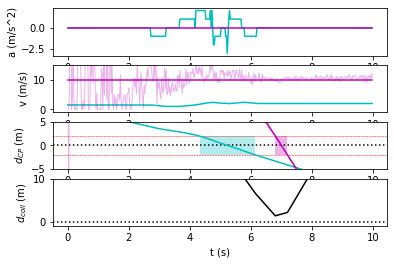

noise scaling = 0.2
(seed = 20)


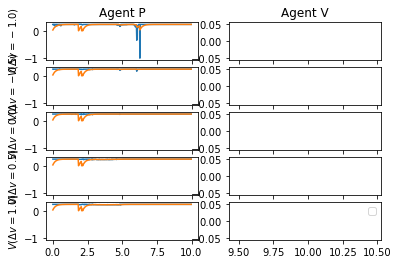

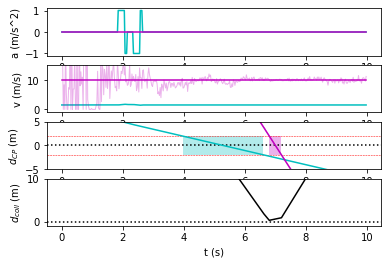

(seed = 21)


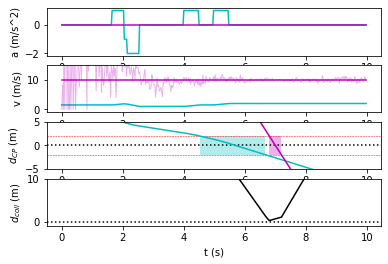

(seed = 22)


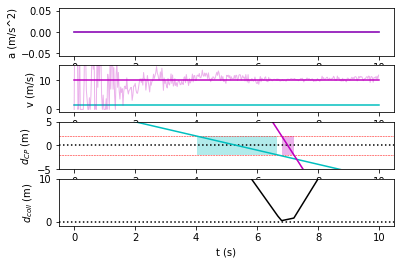

In [12]:
model = 'oVAoSNvoPFoEA'
for obs_noise_scaling in (5, 1, 0.2):
    print(f'noise scaling = {obs_noise_scaling}')
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 1, first_seed = 20, plot_action_val_ests = True)
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 2, first_seed = 21)

### `oVAoSNcoPFoEA` - as with the models without `oPF` it is similar to the `oSNv` option, but not quite as nice-looking

Also sort of nice-looking behaviour - but the `oSNv` one looks nicer I think - overall the `oSNc` often come off as a little more erratic in behaviour? This is all a little subjective though, of course, and only for one parameterisation, etc...

noise scaling = 5
(seed = 20)


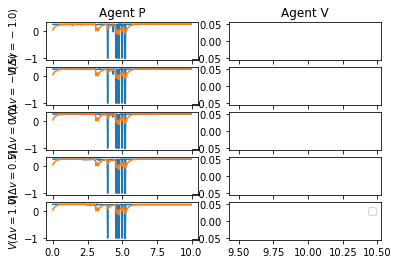

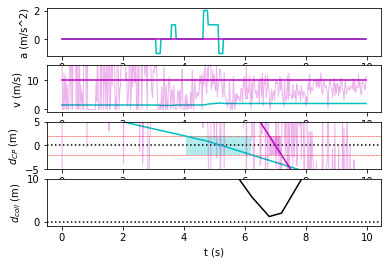

(seed = 21)


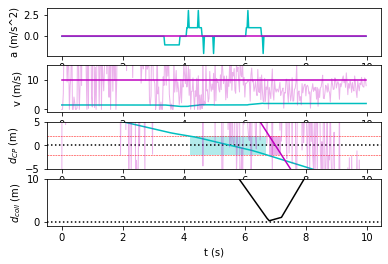

(seed = 22)


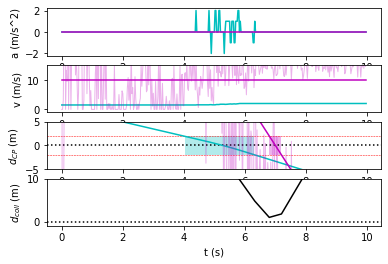

noise scaling = 1
(seed = 20)


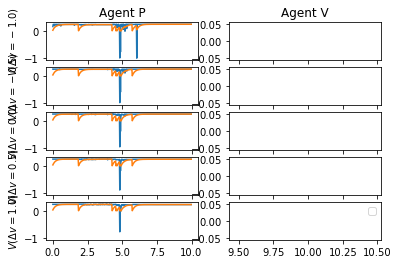

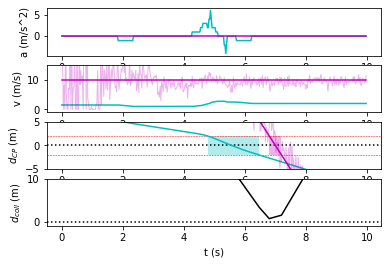

(seed = 21)


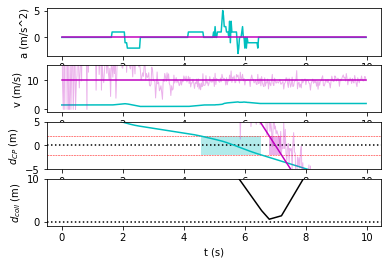

(seed = 22)


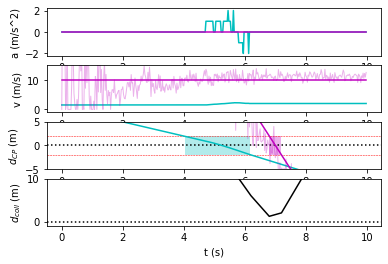

noise scaling = 0.2
(seed = 20)


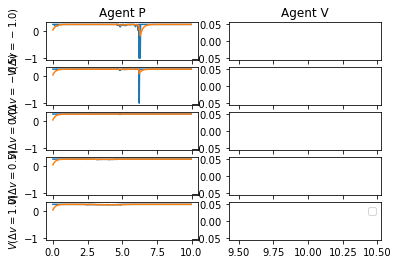

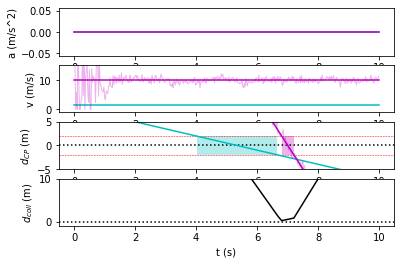

(seed = 21)


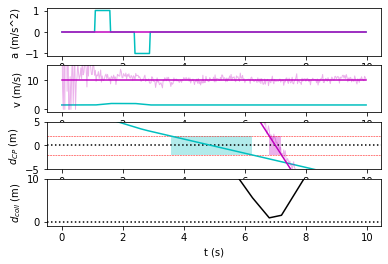

(seed = 22)


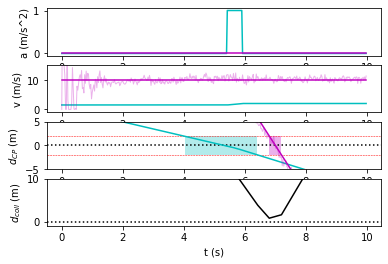

In [13]:
model = 'oVAoSNcoPFoEA'
for obs_noise_scaling in (5, 1, 0.2):
    print(f'noise scaling = {obs_noise_scaling}')
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 1, first_seed = 20, plot_action_val_ests = True)
    run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, n_simulations = 2, first_seed = 21)

### `oVAoSNvoEA` with 0.1 s time step - does not work as nicely as the same model with 0.025 s time step

As one might expect, increasing the time step to something too close to the $T$, the time constant of the `oEA` evidence accumulation, makes the model more like the ones without evidence accumulation...

noise scaling = 0.01
(seed = 20)


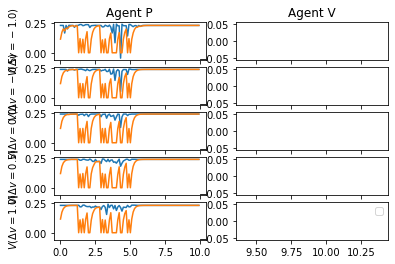

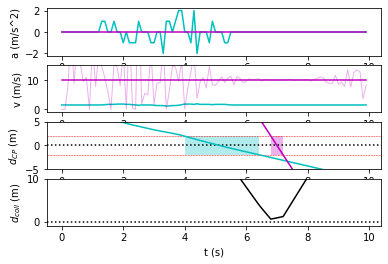

(seed = 21)


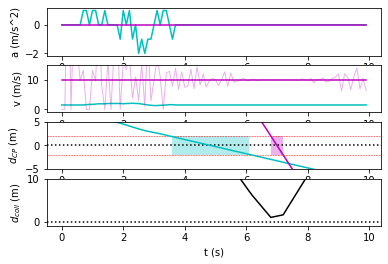

(seed = 22)


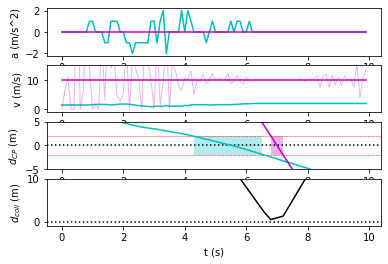

noise scaling = 0.005
(seed = 20)


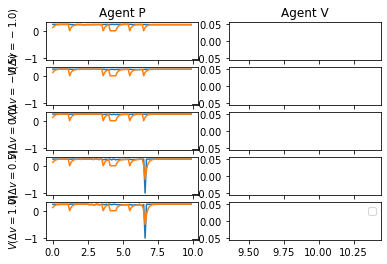

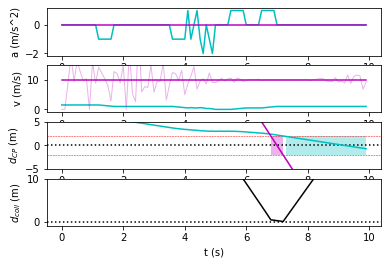

(seed = 21)


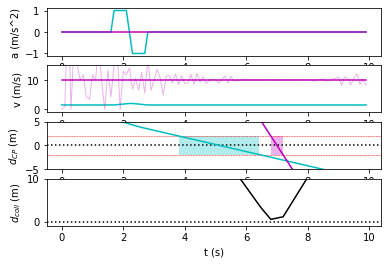

(seed = 22)


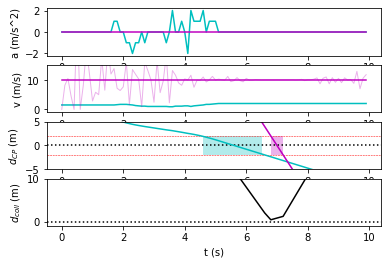

noise scaling = 0.0025
(seed = 20)


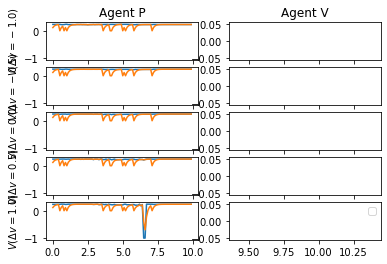

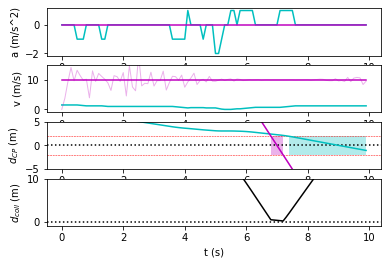

(seed = 21)


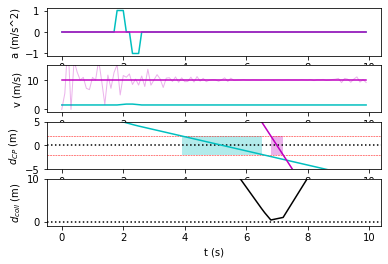

(seed = 22)


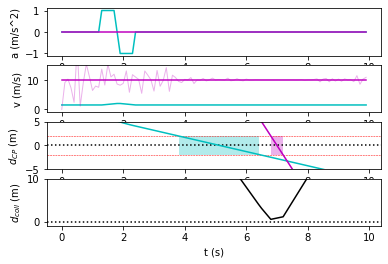

noise scaling = 0.001
(seed = 20)


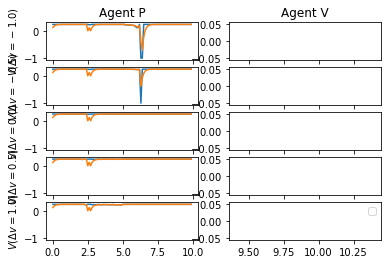

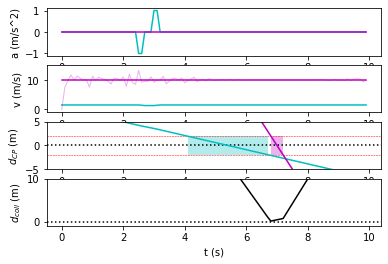

(seed = 21)


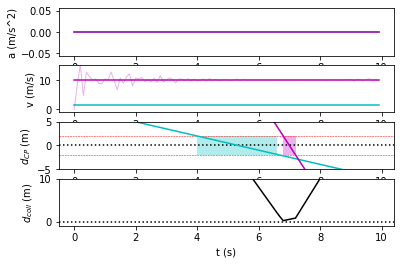

(seed = 22)


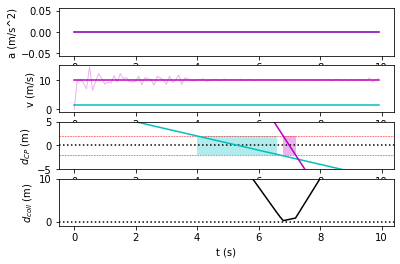

In [14]:
model = 'oVAoSNvoEA'
time_step = 0.1
for obs_noise_scaling in (0.01, 0.005, 0.0025, 0.001):
    print(f'noise scaling = {obs_noise_scaling}')
    run_ped_lead_scenario(model, time_step = time_step, obs_noise_scaling = obs_noise_scaling, n_simulations = 1, first_seed = 20, plot_action_val_ests = True)
    run_ped_lead_scenario(model, time_step = time_step, obs_noise_scaling = obs_noise_scaling, n_simulations = 2, first_seed = 21)

## Closer look at the accumulated value estimates

Rerunning one of the `oVAoSNvoEA` simulations from above. Looking at just the top plot below it's quite hard to see the difference between values for different actions - it's clearer in the surplus value plot. But looking closer at the blue curves in the top plot it's clear that the surplus value being converged to here is a combination of:
* A sort of baseline value for the action, which is lower for the larger-magnitude actions in this specific case, presumably because these actions would be taking the pedestrian further away from the free speed.
* The effect of the sensory noise on the value estimate, which in the first half second here is especially notable for the most negative acceleration action (top panel) - i.e., at this point the model "worries" that slowing down could be quite bad.

(seed = 20)


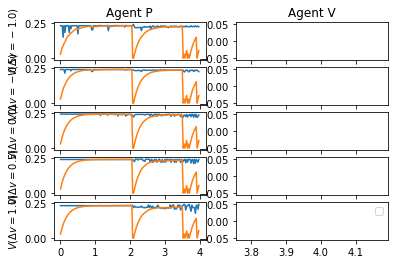

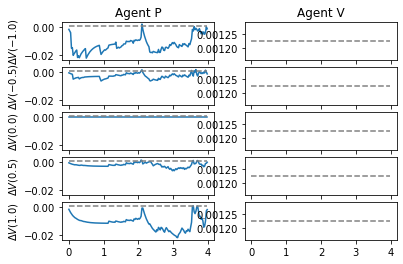

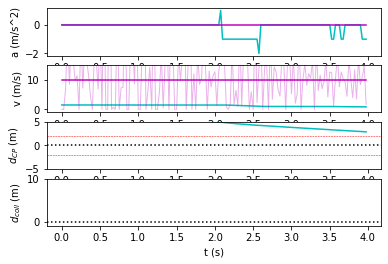

In [15]:
model = 'oVAoSNvoEA'
obs_noise_scaling= 0.0025
run_ped_lead_scenario(model, obs_noise_scaling = obs_noise_scaling, end_time = 4, first_seed = 20, plot_action_val_ests = True, plot_surplus_action_vals = True)

## Also looking at `oAN`

Instead injecting the noise directly into the value evidence accumulation (low pass filtering) results in a model that looks quite erratic in its behaviour. It is still ok at avoiding collisions it seems, since when there is risk of collisions the true values overpower the noise. And there are some indications of hesitation + speedup behaviour - but like with some of the other models above it is not always so clear what is going in since the overall behaviour has a large degree of randomness.

value noise scaling = 10
(seed = 20)


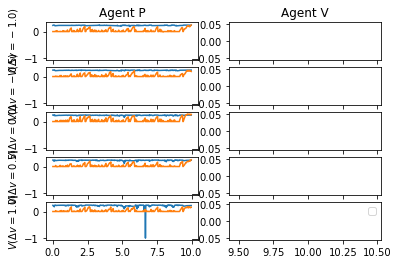

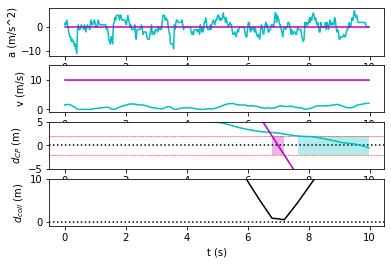

(seed = 21)


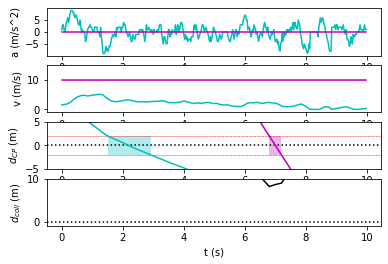

(seed = 22)


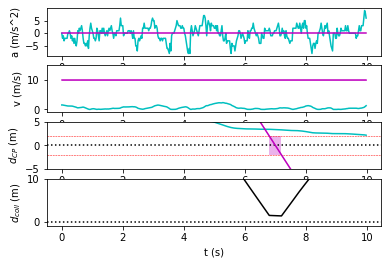

value noise scaling = 5
(seed = 20)


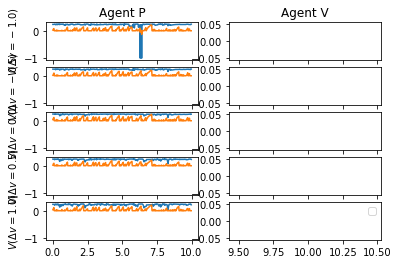

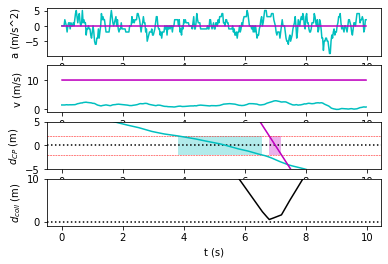

(seed = 21)


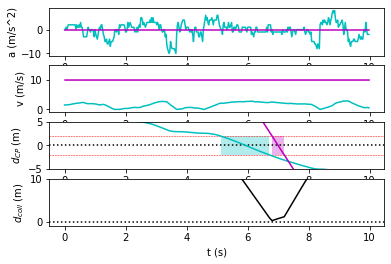

(seed = 22)


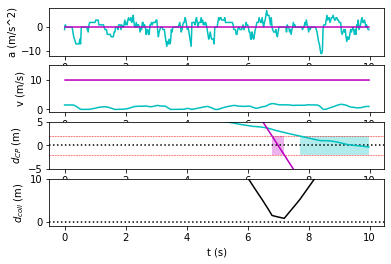

value noise scaling = 2
(seed = 20)


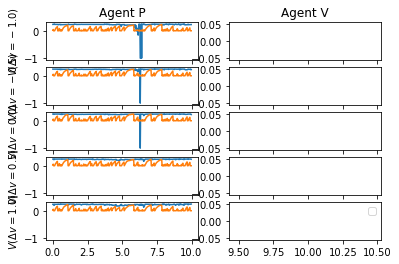

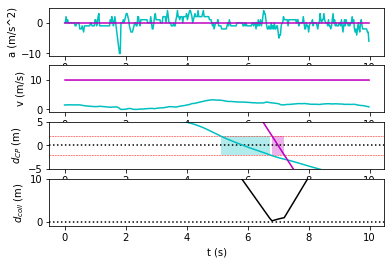

(seed = 21)


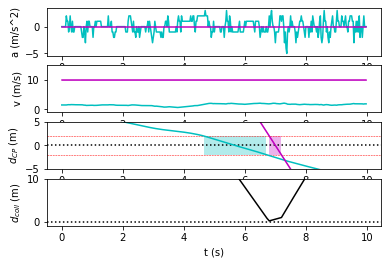

(seed = 22)


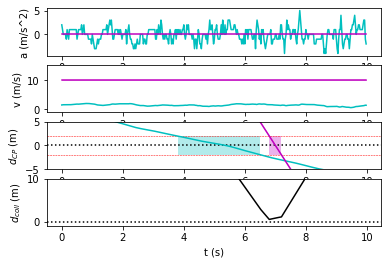

value noise scaling = 1
(seed = 20)


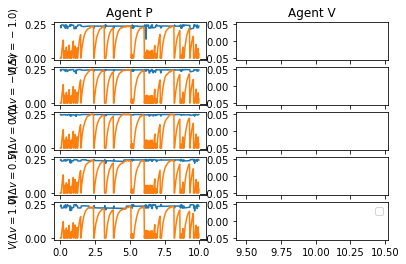

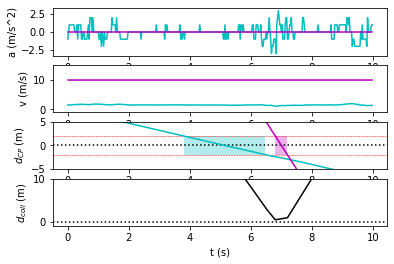

(seed = 21)


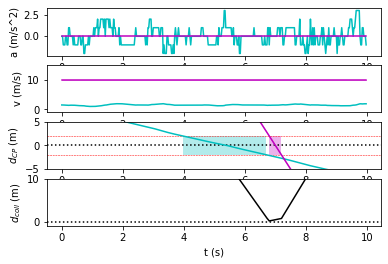

(seed = 22)


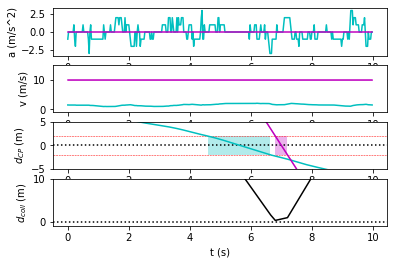

value noise scaling = 0.5
(seed = 20)


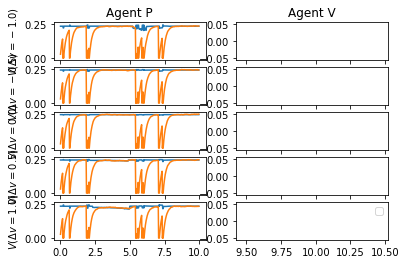

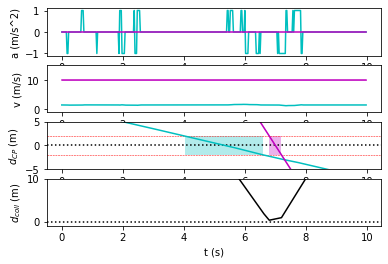

(seed = 21)


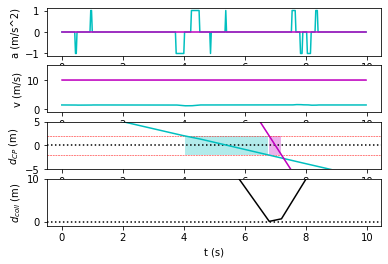

(seed = 22)


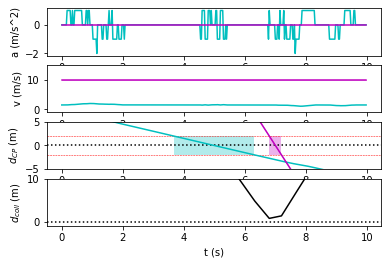

In [23]:
model = 'oVAoEAoAN'
for val_noise_scaling in (10, 5, 2, 1, 0.5):
    print(f'value noise scaling = {val_noise_scaling}')
    run_ped_lead_scenario(model, val_noise_scaling = val_noise_scaling, n_simulations = 1, first_seed = 20, plot_action_val_ests = True)
    run_ped_lead_scenario(model, val_noise_scaling = val_noise_scaling, n_simulations = 2, first_seed = 21)

## Conclusions
* With a small enough time step relative to $T$, noisy perception and evidence accumulation seem enough to generate the hesitation + speed up behaviour, without `oPF`, `oBE*` or `oVAl`.
    * After my preliminary tests with the non-`oPF` noisy models, my impression was that the extremely noisy speed estimates would be completely useless, but that doesn't seem to be the case.
* The `oSNv` models generally seem to generate nicer behaviour than the `oSNc` models.
* Huge caveats here though for only looking at one model parameterisation (except wrt noise level), quite a small number of repetitions in most cases, and only at the `ActPedLeading` type of scenario, with only the pedestrian active.
* It remains to be seen whether models without `oPF` do ok in the other scenarios - or whether the `oPF` filtering is needed there to get the perception to a place where things like `oBE*` and `oAI` can function like they have in the deterministic simulations. 

It seems I have all the model developments in place now for moving on to probabilistic fits.